# Projet SER

In [ ]:
!pip install numpy pandas scikit-learn
!pip install librosa
!pip install mrmr-selection
!pip install soundfile
!pip install librosa
!pip install kaggle

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
#from pymrmr import mRMR
import librosa
#from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA

## Data Collection

### From local path

In [ ]:
"""
def collect_data_ravdess(audio_path):
    data = pd.DataFrame()

    for file in os.listdir(audio_path):
        if file.endswith(".wav"):
            filepath = os.path.join(audio_path, file)
            label = file.split("-")[2]  # Extracting emotion label from filename

            # Append the filepath and label to the DataFrame
            data = data.append({"filepath": filepath, "label": label}, ignore_index=True)

    return data

"""

'\ndef collect_data_ravdess(audio_path):\n    data = pd.DataFrame()\n\n    for file in os.listdir(audio_path):\n        if file.endswith(".wav"):\n            filepath = os.path.join(audio_path, file)\n            label = file.split("-")[2]  # Extracting emotion label from filename\n\n            # Append the filepath and label to the DataFrame\n            data = data.append({"filepath": filepath, "label": label}, ignore_index=True)\n\n    return data\n\n'

### From kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"anisoft17","key":"3b2e4904119c02928bcdb645634cc7b1"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# list datasets on kaggle with the name Ravdess
!kaggle datasets list -s RAVDESS

ref                                           title                                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------  ------------------------------------  -----  -------------------  -------------  ---------  ---------------  
uwrfkaggler/ravdess-emotional-speech-audio    RAVDESS Emotional speech audio        429MB  2019-01-19 18:28:31          37013        461  0.875            
uwrfkaggler/ravdess-emotional-song-audio      RAVDESS Emotional song audio          456MB  2019-01-19 21:01:49           1857         36  0.875            
kartik2khandelwal/speech-emotion-dataset      RAVDESS as .csv                       763KB  2021-09-15 13:12:51            655         17  0.5882353        
dmitrybabko/speech-emotion-recognition-en     Speech Emotion Recognition (en)       987MB  2021-01-25 12:59:50           8215         88  0.875            
uwrfkaggler/ravdess-facial-landmark-tracking  RAVDESS Facial Lan

In [ ]:
# Authenticate into Kaggle and download the required dataset then unzip it in the folder in which we are found

import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('uwrfkaggler/ravdess-emotional-speech-audio', path='.', unzip=True)


## Data Processing
- Audio Normalization
- Silence Removal

In [ ]:
def normalize(X):
    max_X = np.max(np.abs(X))
    Y = X / max_X

    return Y

In [ ]:
def remove_silence(X, factor):
    max_X = np.max(np.abs(X))
    decision_threshold = max_X / factor

    # Find the indices of samples above the decision threshold
    indices_useful_X, _ = find_peaks(np.abs(X), height=decision_threshold)

    # Extract the useful samples
    Y = X[indices_useful_X[0]:indices_useful_X[-1] + 1]

    return Y


In [ ]:
def normalise_remove_silence(input_filename, output_directory, factor):
    # Read the input audio file
    x, fs = librosa.load(input_filename, sr=None)

    # Normalize the audio
    y = normalize(x)

    # Remove silence
    z = remove_silence(y, factor)

    # Extract the filename and extension
    filename, extension = os.path.splitext(os.path.basename(input_filename))

    # Create the output filename in the specified directory
    output_filename = os.path.join(output_directory, f"{filename}_N_RS{factor}{extension}")

    # Write the processed audio to the output file
    sf.write(output_filename, z, fs)

## Audio Feature Extraction with MRMR

In [ ]:
from scipy.stats import mode

def global_feature_computation(feature_matrix, computations):
    computed_features = []
    for computation in computations:
        if computation == "mean":
            computed_features.append(np.mean(feature_matrix, axis=1))
        elif computation == "min":
            computed_features.append(np.min(feature_matrix, axis=1))
        elif computation == "max":
            computed_features.append(np.max(feature_matrix, axis=1))
        elif computation == "std":
            computed_features.append(np.std(feature_matrix, axis=1))
        elif computation == "range":
            computed_features.append(np.ptp(feature_matrix, axis=1))
        elif computation == "mode":
            # Use scipy.stats.mode to get mode and count
            mode_result = mode(feature_matrix, axis=1)
            computed_features.append(mode_result.mode.flatten())
        elif computation == "median":
            computed_features.append(np.median(feature_matrix, axis=1))
        elif computation == "1st_quartile":
            computed_features.append(np.percentile(feature_matrix, 25, axis=1))
        elif computation == "3rd_quartile":
            computed_features.append(np.percentile(feature_matrix, 75, axis=1))
        # Add conditions for other computations

    return np.concatenate(computed_features)

In [ ]:
# extract features available in the librosa library --> list not exhaustiv

def extract_features(audio_path, features, global_computation):
    # Load the normalized and silence-removed audio
    audio, _ = librosa.load(audio_path, sr=None)

    # Placeholder for feature extraction (replace with actual implementation)
    feature_list = []

    # Extract selected features
    for feature_name in features:
        if feature_name == "spectral_flatness":
            spectral_flatness = librosa.feature.spectral_flatness(y=audio)
            feature_list.append(global_feature_computation(spectral_flatness, global_computation))
        elif feature_name == "spectral_centroid":
            spectral_centroid = librosa.feature.spectral_centroid(y=audio)
            feature_list.append(global_feature_computation(spectral_centroid, global_computation))
        elif feature_name == "mfcc":
            mfcc = librosa.feature.mfcc(y=audio)
            feature_list.append(global_feature_computation(mfcc, global_computation))
        #elif feature_name == "delta":
            #mfcc_delta = librosa.feature.delta(mfcc)
            #feature_list.append(global_feature_computation(mfcc_delta, global_computation))
        elif feature_name == "melspectrogram":
            mel_spectrum = librosa.feature.melspectrogram(y=audio)
            feature_list.append(global_feature_computation(mel_spectrum, global_computation))

    # Combine the extracted features into a single feature vector
    feature_vector = np.concatenate(feature_list)

    return feature_vector


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

## Model Training
- SVM

In [ ]:
features = ["spectral_flatness", "spectral_centroid", "mfcc", "melspectrogram"]
#global_computation = ["mean", "min", "max"]
global_computation = ["mean", "min", "max", "std", "range", "mode", "median"]

class_names = ["Neutral", "Cal", "Happiness", "Sadness", "Angry", "Fear", "Disgust", "Surprise"]

factor = 200

num_selected_features = 5

### Normalizing and removing the silence

In [ ]:
# Set the base directory where actor directories are located
base_directory = '/content/audio_speech_actors_01-24'
output_directory = '/content/processed_data'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# First loop: Normalize and remove silence
for actor_directory in os.listdir(base_directory):
    actor_path = os.path.join(base_directory, actor_directory)

    # Check if it's a directory
    if os.path.isdir(actor_path):

        # Iterate over audio files in the actor's directory
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)

            # Normalize and remove silence
            normalise_remove_silence(audio_path, output_directory, factor)


In [ ]:
# List to store the paths of normalized audio files
normalized_audio_paths = []

for audio_file in os.listdir(output_directory):
    normalized_audio_path = os.path.join(output_directory, audio_file)

    # Append to the list of normalized audio paths
    normalized_audio_paths.append(normalized_audio_path)


In [ ]:
normalized_audio_paths

['/content/processed_data/03-01-04-01-02-01-16_N_RS200.wav',
 '/content/processed_data/03-01-07-02-02-01-24_N_RS200.wav',
 '/content/processed_data/03-01-02-01-02-01-02_N_RS200.wav',
 '/content/processed_data/03-01-05-02-02-02-12_N_RS200.wav',
 '/content/processed_data/03-01-04-01-02-01-02_N_RS200.wav',
 '/content/processed_data/03-01-06-01-02-01-22_N_RS200.wav',
 '/content/processed_data/03-01-04-01-02-01-10_N_RS200.wav',
 '/content/processed_data/03-01-04-02-02-01-24_N_RS200.wav',
 '/content/processed_data/03-01-07-02-01-02-13_N_RS200.wav',
 '/content/processed_data/03-01-06-02-01-01-02_N_RS200.wav',
 '/content/processed_data/03-01-02-01-01-02-01_N_RS200.wav',
 '/content/processed_data/03-01-03-01-01-02-02_N_RS200.wav',
 '/content/processed_data/03-01-05-01-02-01-10_N_RS200.wav',
 '/content/processed_data/03-01-06-02-01-01-20_N_RS200.wav',
 '/content/processed_data/03-01-01-01-01-01-14_N_RS200.wav',
 '/content/processed_data/03-01-07-01-02-01-03_N_RS200.wav',
 '/content/processed_dat

In [ ]:
# Initialize lists for audio files, labels, and features
features_list = []
audio_files = []

for normalized_audio_path in normalized_audio_paths:
    extracted_features = extract_features(normalized_audio_path, features, global_computation)

    # Append to lists or perform further processing as needed
    audio_files.append(normalized_audio_path)
    features_list.append(extracted_features)

# Convert features_list to a NumPy array if needed
features_list = np.array(features_list)

In [ ]:
features_list.shape

(1440, 1050)

### labels
Here is the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
labels = []

for actor_directory in os.listdir(base_directory):
    actor_path = os.path.join(base_directory, actor_directory)

     #Check if it's a directory
    if os.path.isdir(actor_path):

        # Iterate over audio files in the actor's directory
        for audio_file in os.listdir(actor_path):
            # Split the file name using the "-" delimiter and take the third part as the emotion label
            parts = audio_file.split("-")
            emotion_label = parts[2]
            labels.append(emotion_label)

In [ ]:
labels = np.array(labels)
labels = labels.astype(np.int64)

In [ ]:
labels.shape

(1440,)

In [ ]:
# Reconstruction of the dataset with the lables from 01 to 07

Y = []
for i in range(labels.size):
  Y.append(labels[i])

display(features_list.shape)
df = pd.DataFrame(features_list)
df['labels'] = Y
df.to_csv('features.csv', index=False)
df.head()

(1440, 1050)

,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,labels
0,0.009756,0.000032,0.086385,0.017197,0.086353,0.000032,0.000605,1631.567904,447.485239,4559.419098,...,0.000096,0.000070,0.000060,0.000054,0.000046,0.000034,1.573269e-05,8.293624e-06,8.076792e-06,7
1,0.012624,0.000012,0.124009,0.021792,0.123997,0.000012,0.000598,1776.764018,517.171399,5113.160960,...,0.000014,0.000013,0.000009,0.000009,0.000008,0.000006,2.695496e-06,7.959048e-07,5.444722e-07,4
2,0.012834,0.000022,0.518166,0.041650,0.518144,0.000022,0.000516,1598.606011,400.956358,4663.523474,...,0.000048,0.000042,0.000029,0.000021,0.000021,0.000016,8.485751e-06,5.207625e-06,5.082602e-06,8
3,0.011124,0.000007,0.077727,0.019126,0.077720,0.000007,0.000660,1745.571068,292.854029,5176.137665,...,0.000006,0.000005,0.000004,0.000002,0.000002,0.000001,3.886319e-07,1.083665e-07,6.216604e-08,6
4,0.067335,0.000028,1.000001,0.180078,0.999972,0.000028,0.000362,1790.006800,0.000000,5646.031694,...,0.000012,0.000010,0.000008,0.000007,0.000008,0.000007,4.220174e-06,3.643544e-06,3.720782e-06,8


In [ ]:
df_norm = df.drop("labels", axis=1)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049
0,0.009756,0.000032,0.086385,0.017197,0.086353,0.000032,0.000605,1631.567904,447.485239,4559.419098,...,0.000105,0.000096,0.000070,0.000060,0.000054,0.000046,0.000034,1.573269e-05,8.293624e-06,8.076792e-06
1,0.012624,0.000012,0.124009,0.021792,0.123997,0.000012,0.000598,1776.764018,517.171399,5113.160960,...,0.000023,0.000014,0.000013,0.000009,0.000009,0.000008,0.000006,2.695496e-06,7.959048e-07,5.444722e-07
2,0.012834,0.000022,0.518166,0.041650,0.518144,0.000022,0.000516,1598.606011,400.956358,4663.523474,...,0.000066,0.000048,0.000042,0.000029,0.000021,0.000021,0.000016,8.485751e-06,5.207625e-06,5.082602e-06
3,0.011124,0.000007,0.077727,0.019126,0.077720,0.000007,0.000660,1745.571068,292.854029,5176.137665,...,0.000007,0.000006,0.000005,0.000004,0.000002,0.000002,0.000001,3.886319e-07,1.083665e-07,6.216604e-08
4,0.067335,0.000028,1.000001,0.180078,0.999972,0.000028,0.000362,1790.006800,0.000000,5646.031694,...,0.000017,0.000012,0.000010,0.000008,0.000007,0.000008,0.000007,4.220174e-06,3.643544e-06,3.720782e-06


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_norm)
print(scaler.mean_)
df_norm = scaler.transform(df_norm)

df_norm = pd.DataFrame(df_norm)
df_norm.head()

[3.65337041e-02 4.21654752e-05 3.44439772e-01 ... 1.34256783e-05
 1.03963443e-05 1.01823297e-05]


,0,1,2,3,4,5,6,7,8,9,...,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049
0,-0.765944,-0.257408,-1.181358,-0.915070,-1.181364,-0.146530,-0.436489,-0.658814,-0.162360,-0.581011,...,0.436180,0.537071,0.353745,0.334709,0.383150,0.339217,0.308683,0.082309,-0.077050,-0.078716
1,-0.683909,-0.786210,-1.009118,-0.832199,-1.009024,-0.146672,-0.437262,-0.305066,0.307439,0.192318,...,-0.408888,-0.499254,-0.502394,-0.556152,-0.509977,-0.497203,-0.486955,-0.382830,-0.351788,-0.360313
2,-0.677887,-0.528622,0.795307,-0.474032,0.795435,-0.146603,-0.445802,-0.739121,-0.476040,-0.435624,...,0.038186,-0.077631,-0.062727,-0.198353,-0.272736,-0.193189,-0.190967,-0.176246,-0.190130,-0.190654
3,-0.726816,-0.915847,-1.220996,-0.880271,-1.220888,-0.146707,-0.430777,-0.381063,-1.204825,0.280268,...,-0.576465,-0.604942,-0.638075,-0.643868,-0.644872,-0.626692,-0.616844,-0.465134,-0.376981,-0.378344
4,0.881029,-0.357902,3.001117,2.022691,3.001310,-0.146557,-0.461839,-0.272802,-3.179138,0.936499,...,-0.474100,-0.521116,-0.558537,-0.562208,-0.544283,-0.480528,-0.466772,-0.328433,-0.247442,-0.241566


In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_norm, labels, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 1050), (1152,), (288, 1050), (288,))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Initialize and train the SVM model
svc_model = SVC()
svc_model.fit(X_train, y_train)
#
#
# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
#
#
# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
#
#
# Initialize and train the Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

In [ ]:
# Make predictions on the test set
y_pred_svc = svc_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

In [ ]:
y_pred_svc.shape, y_pred_knn.shape,  y_pred_gb.shape, y_pred_nn.shape

((288,), (288,), (288,), (288,))

In [ ]:
# Accuracies
accuracy_svc = accuracy_score(y_test, y_pred_svc)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_gb  = accuracy_score(y_test, y_pred_gb)
accuracy_nn  = accuracy_score(y_test, y_pred_nn)

In [ ]:
models = []
accuracies = []

models.append(svc_model)
models.append(knn_model)
models.append(gb_model)
models.append(nn_model)

accuracies.append(accuracy_svc)
accuracies.append(accuracy_knn)
accuracies.append(accuracy_gb)
accuracies.append(accuracy_nn)

model_accuracy_df = pd.DataFrame(models, columns=['Models'])
model_accuracy_df['Accuracies'] = accuracies

In [ ]:
model_accuracy_df

,Models,Accuracies
0,SVC(),0.118056
1,KNeighborsClassifier(),0.142361
2,([DecisionTreeRegressor(criterion='friedman_ms...,0.166667
3,"MLPClassifier(max_iter=1000, random_state=42)",0.145833


## Training with DNN & CNN

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model, Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

In [ ]:
''' Y = []
for i in range(labels.size):
  Y.append(labels[i])
  print(labels[i]) '''

In [ ]:
# Reconstruction of the dataset with the lables from 01 to 07

''' display(features_list.shape)
df = pd.DataFrame(features_list)
df['labels'] = Y
df.to_csv('features.csv', index=False)
df.head() '''

In [ ]:
''' df_norm = df.drop("labels", axis=1)
df_norm.head() '''

In [ ]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_norm)
print(scaler.mean_)
df_norm = scaler.transform(df_norm)

df_norm = pd.DataFrame(df_norm)
df_norm.head() '''

In [ ]:
''' X_train, X_test, y_train, y_test = train_test_split(df_norm, labels, test_size=0.2, random_state=42) '''

In [ ]:
''' # Let check the data shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape '''

In [ ]:
# For use the CNN model, let expand the data dimensions
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 1050, 1), (1152,), (288, 1050, 1), (288,))

In [ ]:
# Modeling

model=Sequential()
model.add(Conv1D(128, kernel_size=5, strides = 1, padding='same', activation=tf.nn.relu, input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation=tf.nn.relu))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=32, activation=tf.nn.relu))
model.add(Dropout(0.3))

model.add(Dense(units=9, activation=tf.nn.softmax))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor  = "val_accuracy",
                   mode     = 'max',
                   verbose  = 0,
                   patience = 30)
mc = ModelCheckpoint('model_best.h5',
                     monitor        = 'val_accuracy',
                     mode           = 'max',
                     verbose        = 1,
                     save_best_only = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1050, 128)         768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 525, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 525, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 525, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 263, 128)          0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 263, 128)          0

In [ ]:
BATCH_SIZE = 100
EPOCHS = 30

history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[es, mc])

Epoch 1/30
 9/10 [==========================>...] - ETA: 0s - loss: 1.3672 - accuracy: 0.4678
Epoch 1: val_accuracy did not improve from 0.17316
10/10 [==============================] - 0s 37ms/step - loss: 1.3669 - accuracy: 0.4669 - val_loss: 2.9914 - val_accuracy: 0.1212
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.3149 - accuracy: 0.4897
Epoch 2: val_accuracy did not improve from 0.17316
10/10 [==============================] - 0s 29ms/step - loss: 1.3149 - accuracy: 0.4897 - val_loss: 3.0830 - val_accuracy: 0.1299
Epoch 3/30
 7/10 [====================>.........] - ETA: 0s - loss: 1.2717 - accuracy: 0.5114
Epoch 3: val_accuracy did not improve from 0.17316
10/10 [==============================] - 0s 24ms/step - loss: 1.2879 - accuracy: 0.5060 - val_loss: 3.2088 - val_accuracy: 0.1299
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.5288
Epoch 4: val_accuracy did not improve from 0.17316
10/10 [=======================

9/9 [==============================] - 0s 7ms/step - loss: 4.4193 - accuracy: 0.1007
Accuracy of our model on test data :  10.06944477558136 %


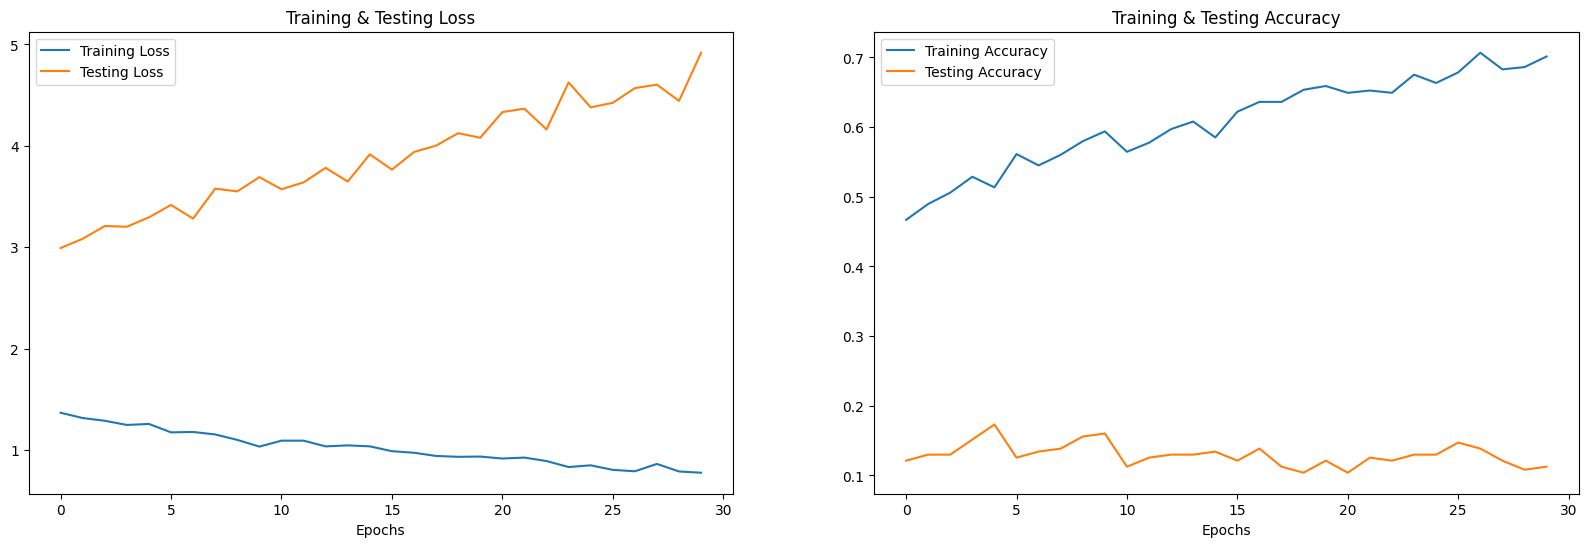

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()